# Laboratorio 4 - Redes Neuronales
### Integrantes:
- Martín Beiro
- Julián Rodríguez

## 1. Objetivo

Para esta tarea se prentende implementar un algoritmo basado en redes neuronales para implementar un modelo de clasificación de imágenes.
Se explorarán diferentes arquitecturas y se evaluará el desempeño de cada modelo para determinar el impacto que tiene el diseño y la selección de los hiperparámetros en los resultados del clasificador.

## 2. Diseño

Se utlizarán imágenes como entrada del modelo, por lo que la estructura de datos a clasificar es una matriz de pixeles. Primero se debe transformar y 'aplanar' los pixeles para obtener un vector tal como si indica en la siguiente figura:

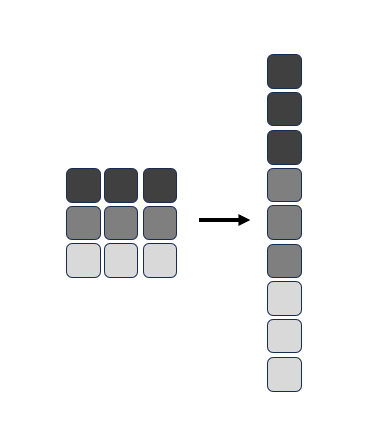

Luego se trabajará con diferentes arquitecturas de redes neuronales *fully connected* donde cada salida de un capa está conectada a la siguiente capa tal como se oberva en la siguiente figura:

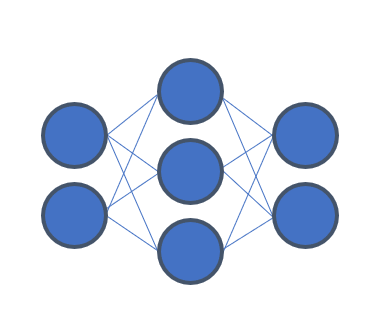


La arquitectura base será una red de una capa de entrada, una capa oculta de 32 neuronas cuya función de activación es la función sigmoide y una capa de salida cuya dimensión se corresponde con la cantidad de categorías a clasificar.

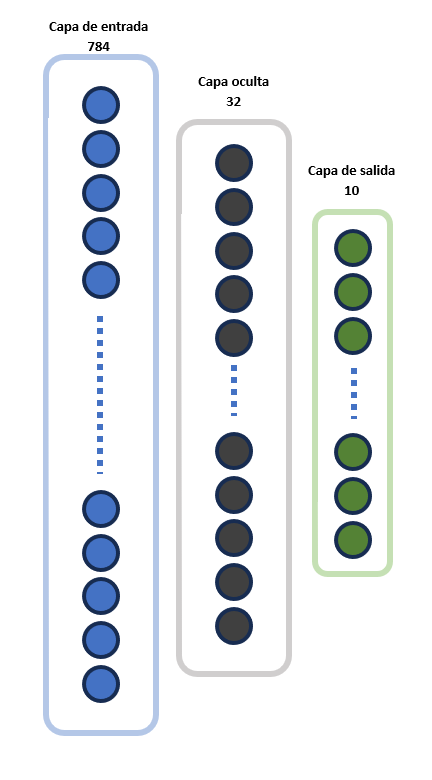

## 3. Implementación

### 3.1. Carga de librerías

La librería en torno a la cual se desarrolla el código es *PyTorch* la cual viene equipada con diferentes funciones previamente implementadas para el diseño e implementación de redes neuronales. También se utilizarán librerías para la adecuación y vizualización de datos.

In [1]:
import torch 
import torchvision
import sklearn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

#elegimos el dispositivo a utilizar. Si hay gpu lo usamos, sino la cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 3.2. Carga de datos

Pytorch incluye facilidades para cargar diferentes conjuntos de datos desde su librería *torchvision*, y en particular cuenta con los datos que se utilizarán para entrenamiento y evaluación.
El set de datos *Fashion-MNIST* es un conjunto de imágenes  de 10 tipos de artículos de vestimenta, con 70.000 imágenes de 28x28 en blanco y negro. Se utilizan 60.000 imágenes para entrenar el modelo y el resto para evaluarlo.
 

In [2]:


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.FashionMNIST(root="./data", train=True,  download=True,  transform=transform, target_transform=None )

test_data = datasets.FashionMNIST(root="./data",train=False, download=True,  transform=transform)
clases=train_data.classes
print(clases)



['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Las clases presentes en el set de datos son: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'

Su muestra una imagen y su categoría:

Text(0.5, 1.0, 'Ankle boot')

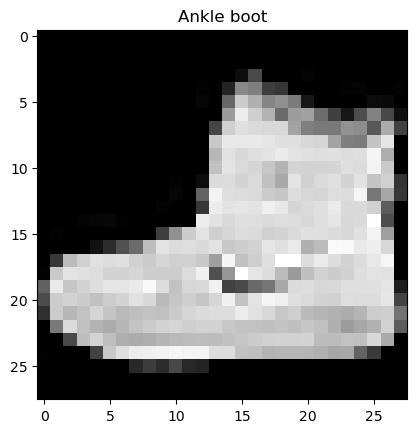

In [3]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(clases[label])

Para entrenar el modelo, conviene crear *Dataloaders* que manejan la división de los conjuntos en lotes. Comenzaremos con un tamaño de lote de típico de 64 muestras. Al modificar la cantidad de muestras del lote, modificamos la memoria que se utiliza en cada iteración, la cantidad de cómputos que se hacen en cada época, y también reducimos la estocasticidad al tomar un subconjunto de muestras más grande.


In [4]:
BATCH_SIZE = 64


train_dataloader =torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,  shuffle=True )

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False )


### 3.3. Red feedforward base

Como base, se construye una red *Feedforward* sencilla, de una capa oculta, 32 unidades y activación Sigmoide. Se puede utilizar a la salida la función *Softmax* para obtener algo que se asemeje a una distribución de probabilidad sobre las categorías. No se realiza en el modelo ya que la función de pérdida lo tiene inclcuido. En las siguientes secciones haremos esfuerzos por mejorar los resultados de la red base modificando hiperparámetros como cantidad de capas ocultas, funciones de activación y cantidad de unides ocultas.

Primero se crea la clase de la red como subclase de *Pytorch Module*, clase base para los modelos en este *framework*. Se debe incorporar una capa *Flatten* para pasar las imágenes a vectores unidimensionales , por lo que cada lote de entrada nos queda con la forma (1,28x28,tamaño del lote).

In [5]:
class FFv0(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_dimention, 10),        
        )
    def forward(self, x):
        return self.capas(x)
    


Luego se crea el loop de entrenamiento y se entrena durante 10 épocas, con un learning rate de 0.01. 

In [6]:
def train_step(model, train_dataloader, loss_fn, optimizer):
    model.train()
    train_loss= 0
    train_acc= 0
    for images, labels in train_dataloader:
        #forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss
        #backprop
        optimizer.zero_grad()
        loss.backward()
        #actualizo el modelo
        optimizer.step()
        predictions=outputs.argmax(dim=1)

        train_acc += ((predictions==labels).sum().item()/len(labels))*100
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    return train_loss, train_acc

def test_step(model, test_dataloader, loss_fn):
    model.eval()
    total=0
    correct=0
    test_loss=0
    test_acc=0
    with torch.inference_mode():
        for images, labels in test_dataloader:
            outputs = model(images)
            test_loss+=loss_fn(outputs, labels)
            predictions=outputs.argmax(dim=1)
            test_acc += ((predictions==labels).sum().item()/len(labels))*100
        # Adjust metrics and print out
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc

def train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=True):
    history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])
    for epoch in range(epochs):



        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        if verbose:
            print(f"Epoca: {epoch+1} ---")

            print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
            print ("------------")
        history["train_loss"].append(train_loss.item())
        history["train_acc"].append(train_acc)

        history["test_acc"].append(test_acc)
        history["test_loss"].append(test_loss.item())
    return history



In [7]:
lr=0.01
epochs=10
torch.manual_seed(55)
model_v0=FFv0(28*28,32).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v0.parameters(), lr=lr)

history_0_10=train_model(model_v0, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 1.66676 | Train accuracy: 55.47%

Test loss: 1.26800 | Test accuracy: 66.83%

------------
Epoca: 2 ---
Train loss: 1.07202 | Train accuracy: 69.93%

Test loss: 0.93968 | Test accuracy: 71.55%

------------
Epoca: 3 ---
Train loss: 0.85280 | Train accuracy: 72.87%

Test loss: 0.80016 | Test accuracy: 73.42%

------------
Epoca: 4 ---
Train loss: 0.74906 | Train accuracy: 74.68%

Test loss: 0.72559 | Test accuracy: 74.73%

------------
Epoca: 5 ---
Train loss: 0.68618 | Train accuracy: 76.21%

Test loss: 0.67495 | Test accuracy: 76.17%

------------
Epoca: 6 ---
Train loss: 0.64139 | Train accuracy: 77.58%

Test loss: 0.63674 | Test accuracy: 77.42%

------------
Epoca: 7 ---
Train loss: 0.60628 | Train accuracy: 78.98%

Test loss: 0.60818 | Test accuracy: 78.58%

------------
Epoca: 8 ---
Train loss: 0.57804 | Train accuracy: 80.07%

Test loss: 0.58336 | Test accuracy: 79.61%

------------
Epoca: 9 ---
Train loss: 0.55494 | Train accuracy: 81.10%

Test loss: 0.

Se observa la evolución del Accuracy y la pérdida, para poder interpretar mejor los resultados.

In [8]:

def plot_results(history,title,ylims=None):
    train_losses = history["train_loss"]
    eval_losses = history["test_loss"]
    train_accs = history["train_acc"]
    eval_accs = history["test_acc"]
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Entrenamiento")
    plt.plot(range(1, len(eval_losses) + 1), eval_losses, label="Evaluación")
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title(f'Pérdida en Entrenamiento y Evaluación {title}')
    plt.grid(True)
    if ylims != None:
        plt.ylim(ylims[0])
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accs) + 1), train_accs, label="Entrenamiento")
    plt.plot(range(1, len(eval_accs) + 1), eval_accs, label="Evaluación")
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Accuracy en Entrenamiento y Evaluación {title}')
    plt.grid(True)
    if ylims != None:
        plt.ylim(ylims[1])
    plt.show()

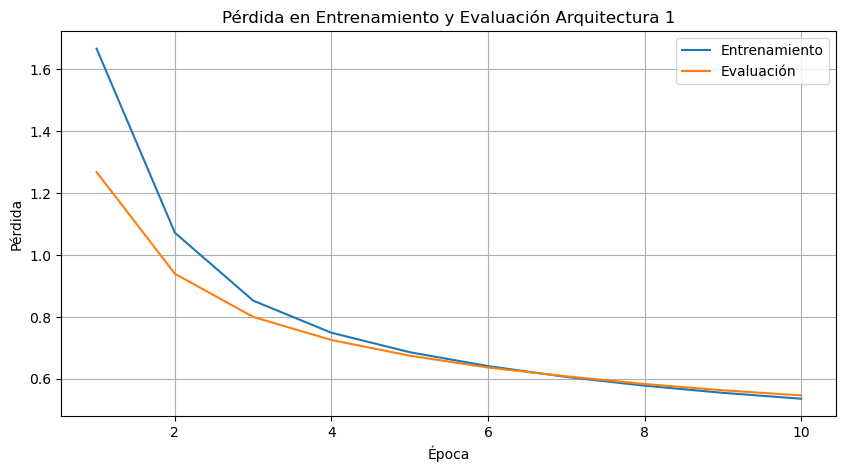

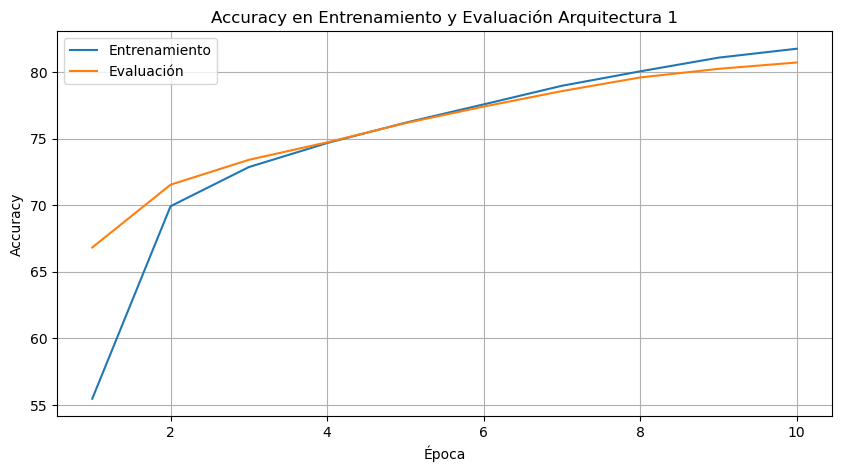

In [9]:



plot_results(history_0_10,'Arquitectura 1')#,[[0.5,2],[20,100]])

La curva de las pérdidas parece correcta, y se observa como se mejora el modelo con el transucrso de las épocas. No se ve overfitting, al menos observando esta gráfica, porque van juntas las pérdidas de entrenamiento y evaluación.
La inicialización se realiza al azar, por lo que la pérdida inicial podría variar en otro caso.


En cuanto a la exactitud, se logra ver como supera al 80% sobre el final del entrenamiento. Se observa un comportamiento similar en ambos conjuntos de datos.

### 3.4. Mejoras en la arquitectura

Con el fin de mejorar los resultados, podemos realizar pruebas modificando algunas características de la red y de su entrenamiento.  
Primero realizamos pruebas aumentando el *learning rate*, para tener un poco de intuición sobre cómo se comporta el modelo.
Se limita a 10 épocas el entrenamiento en esta sección, con el fin de reducir los tiempos de desarrollo en la tarea y poder comparar con el caso anterior. De todas maneras, no descartamos que se puedan obtener mejoras en el desempeño entrenando más épocas, lo cual se realizará al final con el mejor modelo.

In [10]:

lr=0.1
epochs=10
torch.manual_seed(55)
model_v0=FFv0(28*28,32).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v0.parameters(), lr=lr)

history_0_20=train_model(model_v0, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 0.80393 | Train accuracy: 73.95%

Test loss: 0.55767 | Test accuracy: 80.46%

------------
Epoca: 2 ---
Train loss: 0.48880 | Train accuracy: 82.93%

Test loss: 0.48406 | Test accuracy: 82.57%

------------
Epoca: 3 ---
Train loss: 0.43552 | Train accuracy: 84.53%

Test loss: 0.44734 | Test accuracy: 83.76%

------------
Epoca: 4 ---
Train loss: 0.40971 | Train accuracy: 85.34%

Test loss: 0.43880 | Test accuracy: 84.29%

------------
Epoca: 5 ---
Train loss: 0.39202 | Train accuracy: 86.08%

Test loss: 0.43090 | Test accuracy: 84.24%

------------
Epoca: 6 ---
Train loss: 0.38021 | Train accuracy: 86.42%

Test loss: 0.41179 | Test accuracy: 85.30%

------------
Epoca: 7 ---
Train loss: 0.36947 | Train accuracy: 86.88%

Test loss: 0.41557 | Test accuracy: 85.01%

------------
Epoca: 8 ---
Train loss: 0.36065 | Train accuracy: 87.22%

Test loss: 0.42259 | Test accuracy: 84.67%

------------
Epoca: 9 ---
Train loss: 0.35354 | Train accuracy: 87.40%

Test loss: 0.

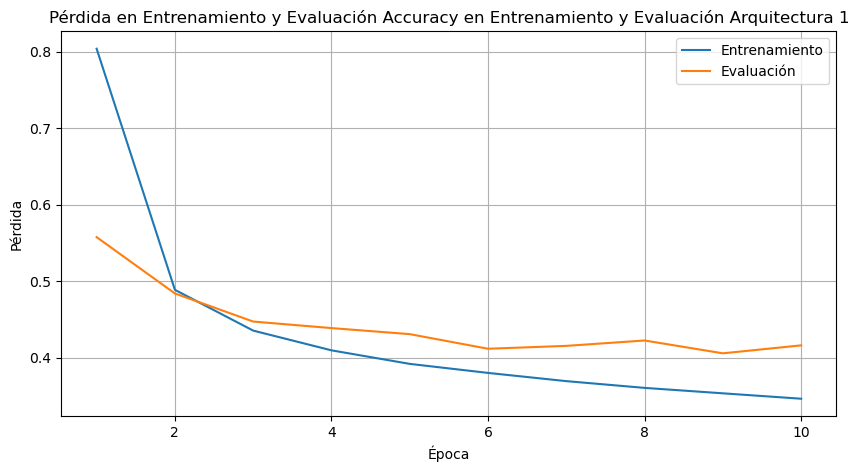

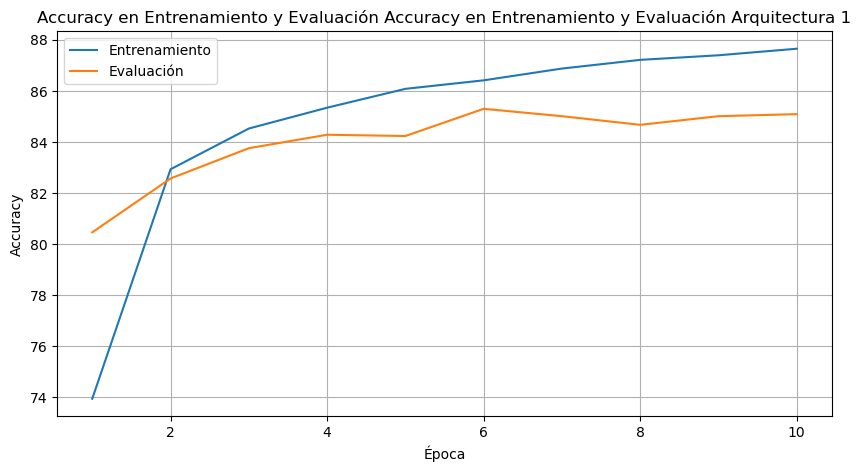

In [11]:
plot_results(history_0_20,'Accuracy en Entrenamiento y Evaluación Arquitectura 1')#,[[0.25,1],[70,95]])

En el gráfico anterior se observa una mejora en la pérdida con solo cambiar el learning rate.

Se observa una mejora en la exactitud con respecto al caso anterior llegando al 85% en el conjunto de evaluación. 


Tomando el resultado obtenido en la época 10, podemos proceder a intentar superarlo. 
Se proponen 3 modificaciones a la arquitectura, que se irán agregando de manera incrementral.

La primera, modificar la función de activación a una ReLU. 
La segunda, agregar una capa intermedia, para ver si más profundidad mejora los resultados.
La tercera, aumentar la cantidad de unidades ocultas.

Este análisis lo haremos con varios valores de *learning rate*.

In [12]:
class FFv1(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimention, 10),        
        )
    def forward(self, x):
        return self.capas(x)

In [13]:
class FFv2(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimention, hidden_dimention),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimention, 10),        
        )
    def forward(self, x):
        return self.capas(x)  
    

    

In [15]:
lrs=[0.05,0.1,0.5]
best_model=None
best_acc=0
best_history=None
epochs=20
histories=[]
for lr in lrs:
    print(f"lr={lr}")
    loss_fn = torch.nn.CrossEntropyLoss()
    model_v1=FFv1(28*28,32).to(device)
    optimizer = torch.optim.SGD(model_v1.parameters(), lr=lr)    

    history=train_model(model_v1, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=False)
    print("Accuracy en test v1: ",history["test_acc"][-1])
    if history["test_acc"][-1]>best_acc:
        best_acc=history["test_acc"][-1]
        best_model=model_v1
        best_history=history

    histories.append(history)


    model_v2=FFv2(28*28,32).to(device)
    optimizer = torch.optim.SGD(model_v2.parameters(), lr=lr)    

    history=train_model(model_v2, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=False)
    print("Accuracy en test v2: ",history["test_acc"][-1])
    if history["test_acc"][-1]>best_acc:
        best_acc=history["test_acc"][-1]
        best_model=model_v2
        best_history=history
    histories.append(history)

    model_v3=FFv2(28*28,64).to(device)
    optimizer = torch.optim.SGD(model_v3.parameters(), lr=lr)    

    history=train_model(model_v3, train_dataloader, test_dataloader, loss_fn, optimizer, epochs,verbose=False)
    print("Accuracy en test v3: ",history["test_acc"][-1])
    if history["test_acc"][-1]>best_acc:
        best_acc=history["test_acc"][-1]
        best_model=model_v3
        best_history=history

    histories.append(history)
    print(best_model)

lr=0.05
Accuracy en test v1:  86.62420382165605
Accuracy en test v2:  86.86305732484077
Accuracy en test v3:  87.22133757961784
FFv2(
  (capas): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)
lr=0.1
Accuracy en test v1:  87.11186305732484
Accuracy en test v2:  87.40047770700637
Accuracy en test v3:  88.71417197452229
FFv2(
  (capas): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)
lr=0.5
Accuracy en test v1:  41.89888535031847
Accuracy en test v2:  46.42714968152866
Accuracy en test v3:  85.59912420382166
FFv2(
  (capas): Sequential(
    (0): 

Los puntajes son muy similares a los de la red base, observemos las gráficas de pérdida y accuracy.

In [16]:
## grille de gráficas de 3x3 con los modelos y los lr en sus pérdidas 
def plot_results_grid(histories,metric,lrs,ylim=None):
    fig, axs = plt.subplots(3, 3,figsize=(15,15))
    for i in range(3):
        for j in range(3):
            history=histories[i*3+j]
            axs[i,j].plot(range(1, len(history["train_"+metric]) + 1), history["train_"+metric], label="Entrenamiento")
            axs[i,j].plot(range(1, len(history["test_"+metric]) + 1), history["test_"+metric], label="Evaluación")
            axs[i,j].set_xlabel('Época')
            if metric == 'loss':
                axs[i,j].set_ylabel('Pérdida')
                axs[i,j].set_title(f'Pérdida en Entrenamiento y Evaluación Arquitectura {j+1} lr={lrs[i]}')
            else:
                axs[i,j].set_ylabel('Accuracy')
                axs[i,j].set_title(f'Accuracy en Entrenamiento y Evaluación Arquitectura {j+1} lr={lrs[i]}')
            axs[i,j].legend()
            
            axs[i,j].grid(True)
            axs[i,j].title.set_size(7)
            #si estan, usar y
            if ylim:
                axs[i,j].set_ylim(ylim)

    plt.show()


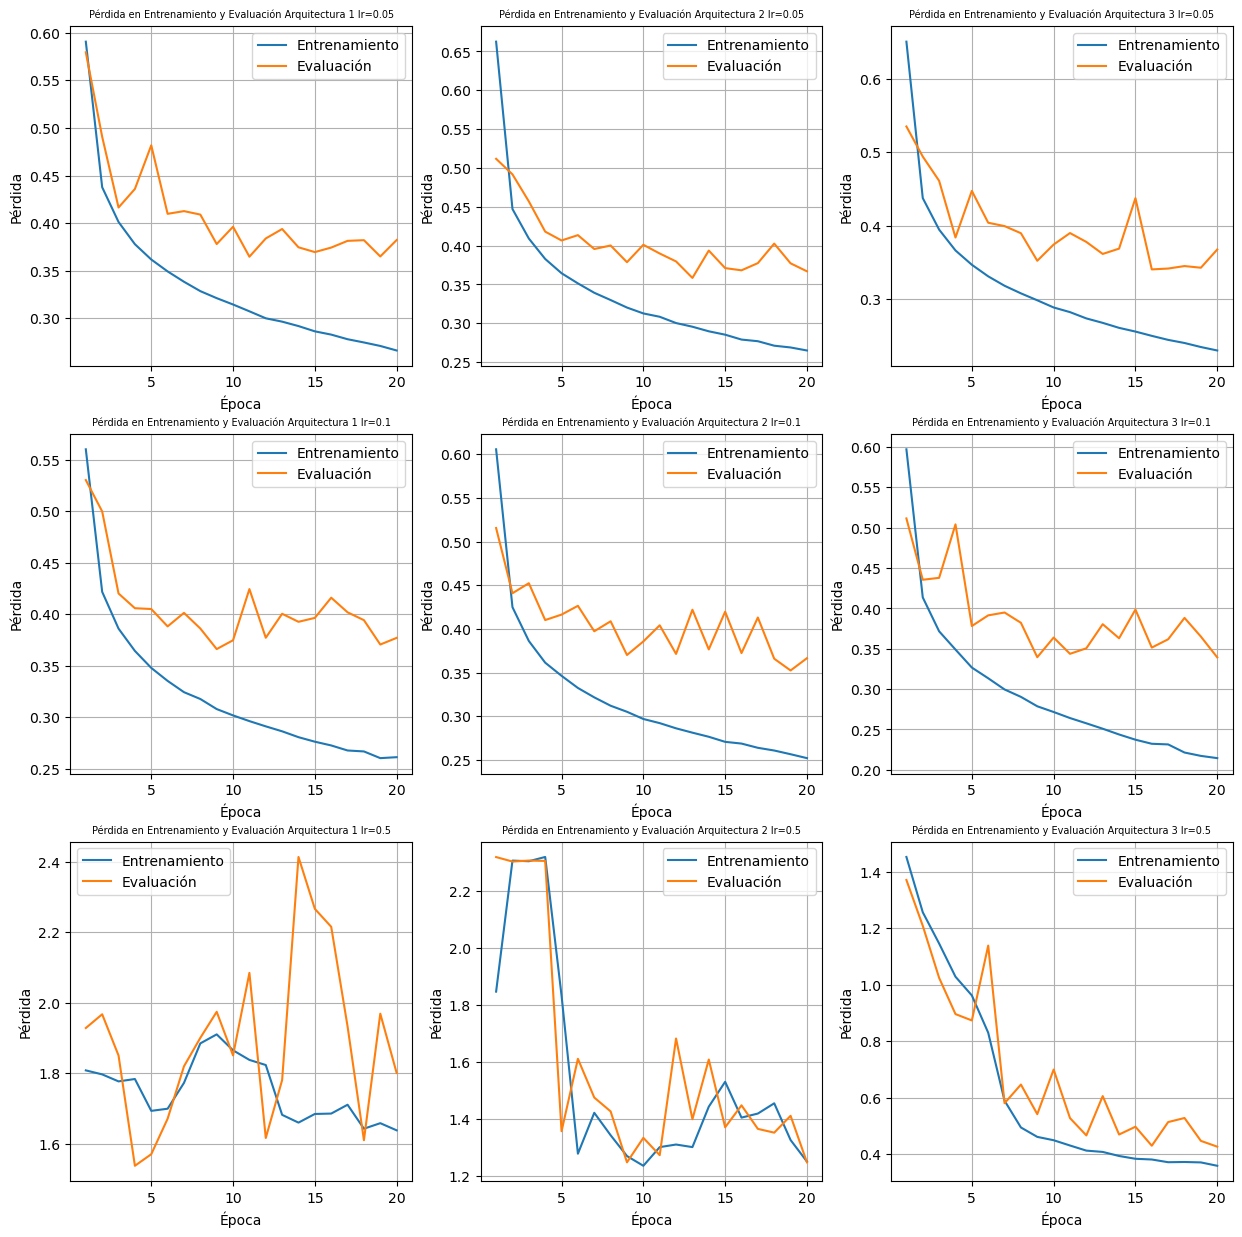

In [17]:

plot_results_grid(histories,"loss",lrs)

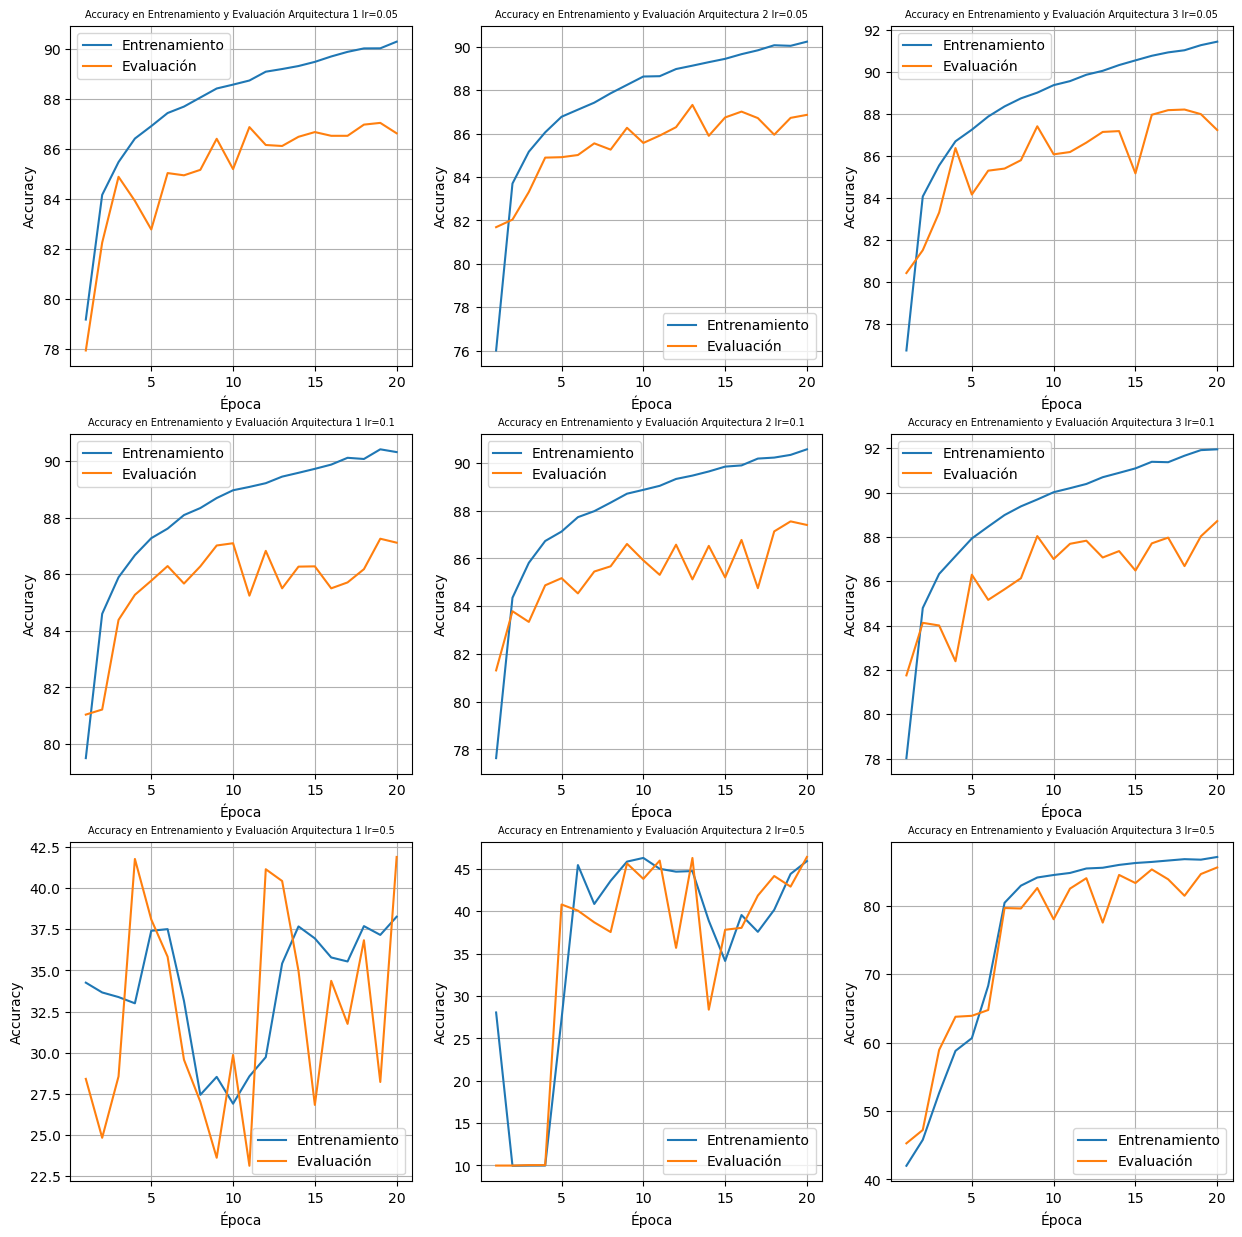

In [18]:

plot_results_grid(histories,"acc",lrs)

Partiendo de las gráficas anteriores, encontramos que para *learning rate* 0.5 el comportamiento es muy inestable.

Concentrando el análisis en lr 0.05 y 0.1, vemos que las curvas de *accuracy* en entrenamiento y evaluación presentan valores similares al modelo base, aunque se logra un valor superior de validación en el modelo tres. A su vez, las curvas se separan entre sí, lo que puede significar que tenemos margen de mejora reduciendo el sobreajuste. Para esto, en la siguiente etapa se introducirá regulariazación. Se utiliza el tercer modelo para probar esta modificación al algoritmo, con un learning rate de 0.1.

### 3.5. Regularización

Los métodos de regularización  mediante la introducción de un factor de penalización, cambios en la estructura de la red, o modificaciones al conjunto de datos, intentan evitar que el modelo pueda ajustarse demasiado al conjunto de entrenamiento.
En este caso, utilizaremos *dropout*, que consiste en desactivar partes de la red en distintas iteraciones del entrenamiento para evitar que las neuronas aprendan características muy particulares de algunas muestras, y en cambio, aprendan las características más generales del conjunto. 

In [19]:
class FFv3(torch.nn.Module):
    def __init__(self,input_shape,hidden_dimention):
        super().__init__()
        self.capas= torch.nn.Sequential(  
        torch.nn.Flatten(),
        torch.nn.Linear(input_shape, hidden_dimention),
        torch.nn.Dropout(0.25),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.25),
        torch.nn.Linear(hidden_dimention, hidden_dimention),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dimention, 10),        
        )
    def forward(self, x):
        return self.capas(x)  

In [20]:
lr=0.1
epochs=60
torch.manual_seed(55)
model_v3=FFv3(28*28,64).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_v3.parameters(), lr=lr)

history_3_60=train_model(model_v3, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 0.71547 | Train accuracy: 73.79%

Test loss: 0.65333 | Test accuracy: 75.92%

------------
Epoca: 2 ---
Train loss: 0.52277 | Train accuracy: 80.99%

Test loss: 0.45340 | Test accuracy: 82.96%

------------
Epoca: 3 ---
Train loss: 0.48647 | Train accuracy: 82.14%

Test loss: 0.46816 | Test accuracy: 82.05%

------------
Epoca: 4 ---
Train loss: 0.46189 | Train accuracy: 83.19%

Test loss: 0.43614 | Test accuracy: 83.94%

------------
Epoca: 5 ---
Train loss: 0.44698 | Train accuracy: 83.66%

Test loss: 0.40307 | Test accuracy: 85.37%

------------
Epoca: 6 ---
Train loss: 0.42818 | Train accuracy: 84.37%

Test loss: 0.39733 | Test accuracy: 85.68%

------------
Epoca: 7 ---
Train loss: 0.42080 | Train accuracy: 84.62%

Test loss: 0.39280 | Test accuracy: 85.90%

------------
Epoca: 8 ---
Train loss: 0.41180 | Train accuracy: 84.87%

Test loss: 0.39086 | Test accuracy: 85.58%

------------
Epoca: 9 ---
Train loss: 0.40508 | Train accuracy: 85.06%

Test loss: 0.

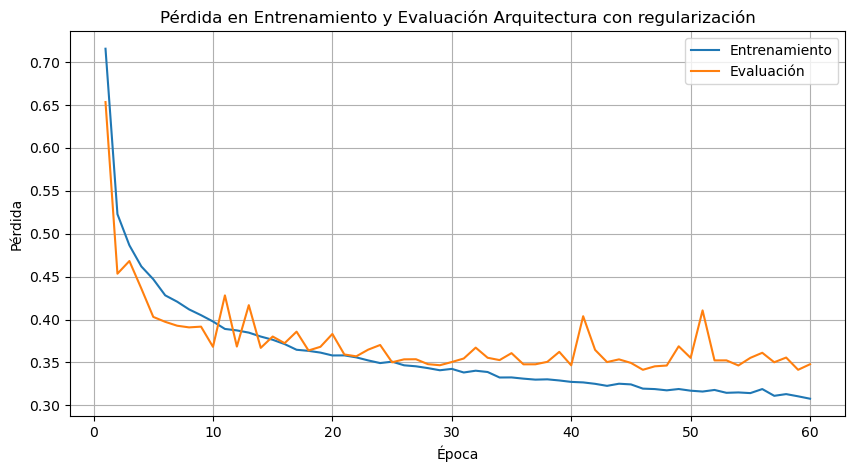

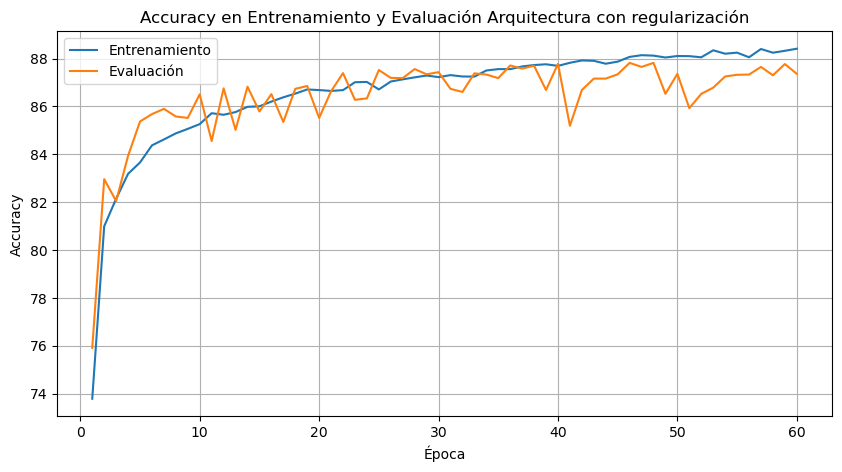

In [21]:
plot_results(history_3_60,'Arquitectura con regularización')#,[[0.25,0.8],[70,90]])

Vemos como el efecto de la regularización es evidente, logrando mantener el error de generalización bajo, con el modelo que aprende pero no sobreajusta a los datos de entrenamiento, superando una exactitud de 87%, y con perspectivas de seguir subiendo si se entrenan más épocas. 

In [22]:
#path="./models/model_v3.pt"
#torch.save(model_v3.state_dict(), path)
# model = FFv3(28*28,64).to(device)
# model.load_state_dict(torch.load(path))

## 4. Evaluación de desempeño

Para poder evaluar el desempeño del clasificador se utilizarán las métricas *precision*, *recall* y *F1* proporcionadas por la librería *sklearn*. También se construye la matriz de confusión.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [24]:
#evaluar el modelo
model_v3.eval()
total=0
correct=0
test_loss=0
test_acc=0
predicted_labels=[]
true_labels=[]
with torch.inference_mode():
    for images, labels in test_dataloader:
        outputs = model_v3(images)
        test_loss+=loss_fn(outputs, labels)
        predictions=outputs.argmax(dim=1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.numpy())

# Calcular las métricas
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Construir la matriz de confusión
confusion = confusion_matrix(true_labels, predicted_labels)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


Accuracy: 0.87
Precision: [0.83441558 0.99177801 0.77065924 0.79099405 0.79130435 0.94054581
 0.75286624 0.94082247 0.96146245 0.96177062]
Recall: [0.771 0.965 0.83  0.931 0.819 0.965 0.591 0.938 0.973 0.956]
F1: [0.8014553  0.97820578 0.79922966 0.85530547 0.804914   0.95261599
 0.66218487 0.93940911 0.96719682 0.95887663]


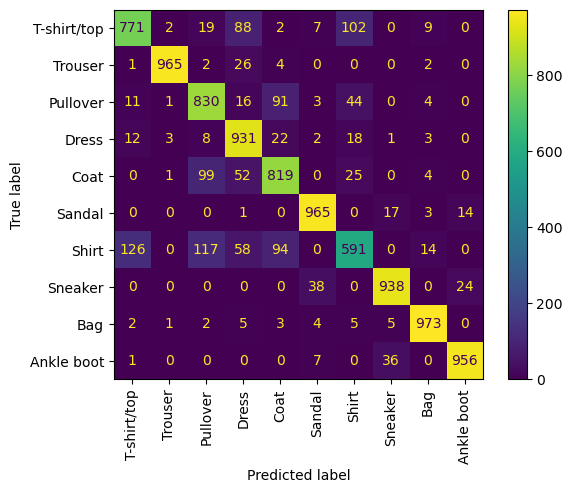

In [25]:
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, display_labels=clases, xticks_rotation=90)


La exactitud es del 87%.  Se presentan los resultados de las otras métricas en la siguiente tabla:

|   Categoría | precision | recall | F1   |
|------------:|-----------|--------|------|
| T-shirt/top | 0.83      | 0.77   | 0.80 |
| Trouser     | 0.99      | 0.97   | 0.98 |
| Pullover    | 0.77      | 0.83   | 0.80 |
| Dress       | 0.79      | 0.93   | 0.86 |
| Coat        | 0.79      | 0.82   | 0.80 |
| Sandal      | 0.94      | 0.97   | 0.95 |
| Shirt       | 0.75      | 0.59   | 0.66 |
| Sneaker     | 0.94      | 0.94   | 0.94 |
| Bag         | 0.96      | 0.97   | 0.97 |
| Ankle boot  | 0.96      | 0.96   | 0.96 |

Un resultado más gráfico se observa en la matriz de confusión.


Se observa como la categoría con menos exactitud es *Shirt* (camisa), y se confunde es con *T-shirt/top* (remera), *Pullover* y *Coat* (abrigo) lo que es razonable ya que algunos presentan formas similares a buzos o camisetas y se parecen entre ellos. 

## 5. Estudio de errores

Se pueden obtener las instancias que resultan más complicadas de clasificar calculando la entropía. Para ello se utilizan los valores que otorga el clasificador para cada categoría de una instancia ya que son semejantes a una distribución de probabilidad. Luego se ordenan y se obtienen los de mayor valor.

$$H=-\sum_i P(x_i)log(P(x_1))$$


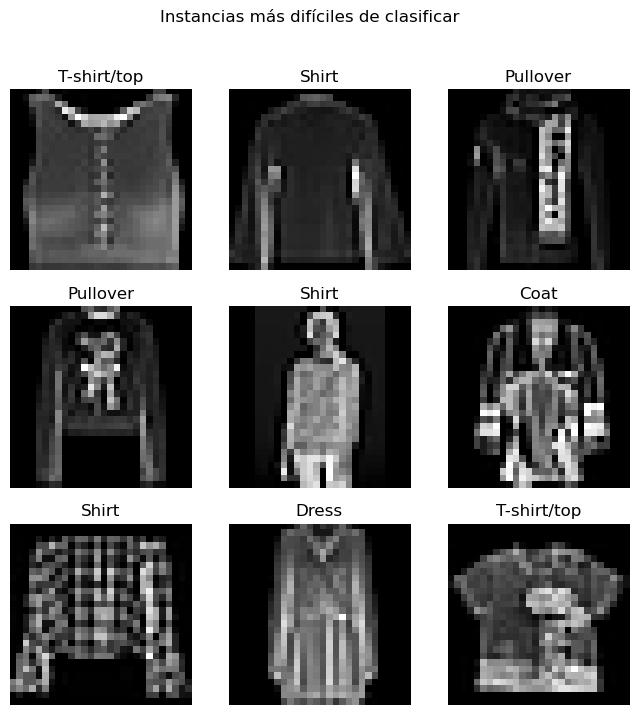

In [26]:
entropies = []

for i, data in enumerate(test_data, 0):
    inputs, _ = data
    outputs = model_v3(inputs)
    softmax = torch.nn.functional.softmax(outputs, dim=1)    
    log_softmax = torch.log(softmax)
    entropy = -torch.sum(softmax * log_softmax, dim=1).detach().numpy()
    entropies.append(entropy)

entropies = np.array(entropies)
difficult_samples_indices = np.flip(np.argsort(entropies, axis=0)[-10:])

#print(difficult_samples_indices)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = difficult_samples_indices[i-1][0]
    image, label = test_data[sample_idx]
    image = image.numpy()
    image = image / 2 + 0.5
    figure.add_subplot(rows, cols, i)
    plt.title(clases[label])
    plt.axis("off")
    plt.imshow(image[0], cmap='gray') 

figure.suptitle('Instancias más difíciles de clasificar')      
plt.show()

Se puede observar como las imágenes más difíciles para el clasificador pueden resultar confusas por presentar la mayoría de los pixles que integran la prenda parecidos al fondo o parecidos a otro tipo de categoría.

## 6. Comparación con otras arquitecturas

A modo de ejemplo, se entrena un modelo de CNN sencillo para comparar su desempeño en las mismas condiciones.
Se utilizó como ejemplo el modelo del siguiente link https://poloclub.github.io/cnn-explainer/

In [27]:
class CNN_v0(torch.nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,   kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2,  stride=2) 
        )
        self.block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [28]:
lr=0.1
epochs=10
torch.manual_seed(55)
model_CNN=CNN_v0(1,10,10).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=lr)

history_CNN_60=train_model(model_CNN, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

Epoca: 1 ---
Train loss: 0.69758 | Train accuracy: 75.75%

Test loss: 0.42442 | Test accuracy: 84.09%

------------
Epoca: 2 ---
Train loss: 0.36988 | Train accuracy: 86.64%

Test loss: 0.37995 | Test accuracy: 86.27%

------------
Epoca: 3 ---
Train loss: 0.32511 | Train accuracy: 88.48%

Test loss: 0.32856 | Test accuracy: 88.05%

------------
Epoca: 4 ---
Train loss: 0.30014 | Train accuracy: 89.19%

Test loss: 0.32016 | Test accuracy: 88.76%

------------
Epoca: 5 ---
Train loss: 0.28219 | Train accuracy: 90.01%

Test loss: 0.33932 | Test accuracy: 88.54%

------------
Epoca: 6 ---
Train loss: 0.27003 | Train accuracy: 90.48%

Test loss: 0.32171 | Test accuracy: 88.18%

------------
Epoca: 7 ---
Train loss: 0.26000 | Train accuracy: 90.70%

Test loss: 0.30149 | Test accuracy: 89.32%

------------
Epoca: 8 ---
Train loss: 0.25201 | Train accuracy: 90.88%

Test loss: 0.28902 | Test accuracy: 89.91%

------------
Epoca: 9 ---
Train loss: 0.24579 | Train accuracy: 91.18%

Test loss: 0.

In [29]:
# path="./models/model_CNN.pt"
# #torch.save(model_CNN.state_dict(), path)
# model = CNN_v0(1,10,10).to(device)
# model.load_state_dict(torch.load(path))

Al correr el algoritmo, se observa que dentro de las 10 épocas alcanza a un desempeño de casi 89% en tan solo 10 épocas, lo que habla de la superioridad de esta arquitectura para esta aplicación.

## 7. Conclusiones

En este laboratorio vimos lo que involucra entrenar una red *FeedForward*. Se logró observar como los distintos hiperparámetros afectan el desempeño del clasificador y los tiempos de entrenamiento. La incorporación de metodologías de regularización como *dropout* puede ayudar a obtener mejores resultados. Se logró un desempeño razonable para la arquitectura utilizada. También se vio que existen otros tipos de arquitecturas como las CNN que obtienen un mejor desempeño en este tipo de aplicaciones.